# 1. Jet Data

In [1]:
from utils import Configs
from jetdata import JetDataclass

config = Configs("configs.yaml")
jets = JetDataclass(config=config)
jets.preprocess()


INFO: created experiment instance GaussNoise_to_AspenOpenJets_MultiModalEPiC_2024.12.20_17h13_1999


/home/df630/Multimodal-Bridges/utils.py:393: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


### inspect data

In [3]:
jets.source.continuous.shape, jets.source.discrete.shape, jets.source.mask.shape

(torch.Size([71604, 128, 3]),
 torch.Size([71604, 128, 1]),
 torch.Size([71604, 128, 1]))

In [4]:
jets.target.continuous.shape, jets.target.discrete.shape, jets.target.mask.shape

(torch.Size([71604, 128, 3]),
 torch.Size([71604, 128, 1]),
 torch.Size([71604, 128, 1]))

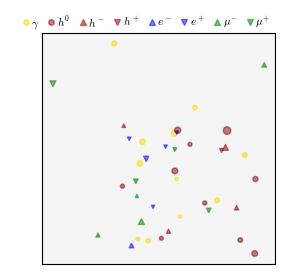

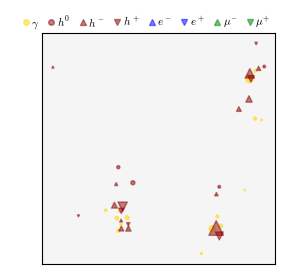

In [6]:
jets.source.display_cloud(idx=0, scale_marker=10.0)
jets.target.display_cloud(idx=10, scale_marker=1.0)

### point-cloud feature histograms

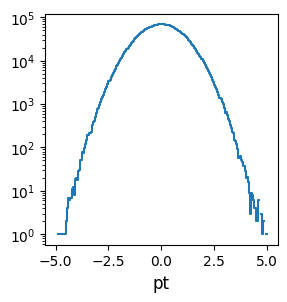

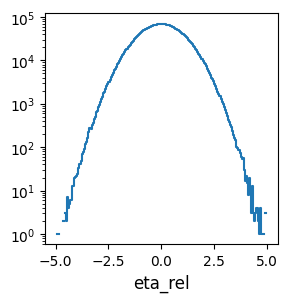

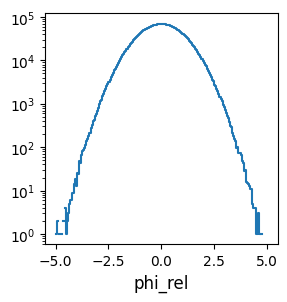

In [2]:
jets.source.histplot(
    feature="pt", fill=False, binrange=(-5, 5), binwidth=0.05, log_scale=(False, True)
)  # momentum distrbution
jets.source.histplot(
    feature="eta_rel",
    fill=False,
    binrange=(-5, 5),
    binwidth=0.05,
    log_scale=(False, True),
)  # momentum distrbution
jets.source.histplot(
    feature="phi_rel",
    fill=False,
    binrange=(-5, 5),
    binwidth=0.05,
    log_scale=(False, True),
)  # momentum distrbution


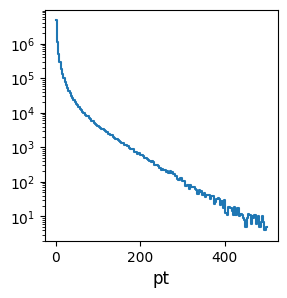

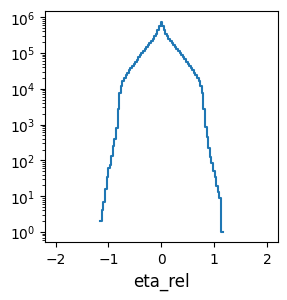

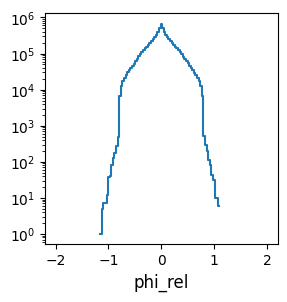

In [13]:
jets.target.histplot(
    feature="pt", fill=False, binrange=(0, 500), binwidth=3, log_scale=(False, True)
)  # momentum distrbution
jets.target.histplot(
    feature="eta_rel",
    fill=False,
    binrange=(-2, 2),
    binwidth=0.03,
    log_scale=(False, True),
)  # eta distribution
jets.target.histplot(
    feature="phi_rel",
    fill=False,
    binrange=(-2, 2),
    binwidth=0.03,
    log_scale=(False, True),
)  # phi distribution

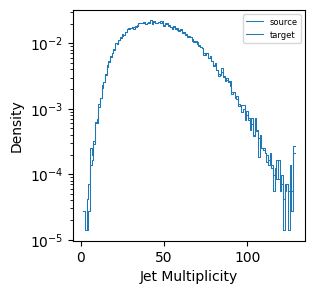

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.histplot(
    jets.source.multiplicity,
    element="step",
    fill=False,
    discrete=True,
    lw=0.75,
    stat="density",
    log_scale=(False, True),
    ax=ax,
    label="source",
)
sns.histplot(
    jets.target.multiplicity,
    element="step",
    fill=False,
    discrete=True,
    lw=0.75,
    stat="density",
    log_scale=(False, True),
    ax=ax,
    label="target",
)
ax.legend(fontsize=6)
ax.set_xlabel("Jet Multiplicity")
plt.show()

In [6]:
config.data.print()

target:
    name: AspenOpenJets
    path: ['/home/df630/CMB/data/AOJ/2016H_job0.h5']
    params:
        min_num_particles: 0
        max_num_particles: 128
    preprocess:
        continuous: standardize
        discrete: tokens
        stats:
            mean: [7.47517728805542, 0.00039798623765818775, 0.00024995606509037316]
            std: [19.519119262695312, 0.252874493598938, 0.25943297147750854]
            min: [0.0, -1.1116657257080078, -1.144480586051941]
            max: [1045.0, 1.1317514181137085, 1.0864198207855225]
source:
    name: GaussNoise
    path: None
    params:
        scale: 1.0
        min_num_particles: 0
        max_num_particles: 128
    preprocess:
        continuous: None
        discrete: tokens
        stats: None
dim:
    features_continuous: 3
    features_discrete: 1
    context_continuous: 0
    context_discrete: 0
vocab_size:
    features: 8
    context: 0


# 2. Train bridge:

In [7]:
import lightning as L

from utils import DataloaderModule
from bridges import AbsorbingBridgeMatching
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82",
        metrics_text_delimiter="\n",
        metrics_format=".3e",
    )
)

dataloader = DataloaderModule(config=config, dataclass=jets)
abm = AbsorbingBridgeMatching(config)

model = L.Trainer(
    max_epochs=config.train.epochs,
    log_every_n_steps=5,
    accelerator="gpu",
    devices=[3],
    gradient_clip_val=1.0,
    callbacks=[progress_bar],
    logger=True,
)


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 57283, validation size: 14320, testing sizes: 0


/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
model.fit(abm, train_dataloaders=dataloader.train, val_dataloaders=dataloader.valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name               ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder            │ MultiModalEPiC   │  827 K │ train │
│ 1 │ loss_continuous_fn │ MSELoss          │      0 │ train │
│ 2 │ loss_discrete_fn   │ CrossEntropyLoss │      0 │ train │
└───┴────────────────────┴──────────────────┴────────┴───────┘

Trainable params: 827 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 827 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 70                                                                                          
Modules in eval mode: 0

Output()

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors
/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors
/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=100` reached.
